<a href="https://colab.research.google.com/github/freison/DeepLearning/blob/master/Lab3_rl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: Model-Free Reinforcement Learning

## Part 1: Cartpole

In [2]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay scikit-video > /dev/null 2>&1

import tensorflow as tf
tf.enable_eager_execution()

import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
import time

# Download the class repository
! git clone https://github.com/aamini/introtodeeplearning_labs.git  > /dev/null 2>&1
% cd introtodeeplearning_labs 
! git pull
% cd ..

import introtodeeplearning_labs as util

/content/introtodeeplearning_labs
Already up to date.
/content


### 1.1 Define and inspect the environment

In [0]:
'''In order to model our enviroment we will use OpenAI Gym, RL algorithms in many aspects are random,
   So we are going to use a seed.'''
env = gym.make("CartPole-v0")
env.seed(1) # Reproducible, since RL has high variance.

[1L]

Observations:

1.   position of cart
2.   velocity of cart.
3.   angle of pole.
4.   rotation rate of pole.

In [0]:
'''We can confirm the size of the space by querying the observation space:'''
print("Enviroment has observation space = {}".format(env.observation_space))

Enviroment has observation space = Box(4,)


In [0]:
'''At every time step, the agent can move either right or left.
   Confirm the size of the action space by querying the environment'''
n_actions = env.action_space.n
print("Number of possible actions that the agent can choose from = {}".format(n_actions))

Number of possible actions that the agent can choose from = 2


### 1.2 Define the agent

In [0]:
'''Let´s define our agent, which is simply a deep neural network which takes as input an observation of the environment 
   and outputs the probability of taking each of the possible actions.'''
def create_cartpole_model():
  model = tf.keras.Sequential([
      tf.keras.layers.Dense(units = 32, activation = 'relu'),
      # TODO: define the output dimension of the last Dense layer
      # Hint: think about that the space the agent needs to act in
      tf.keras.layers.Dense(units = n_actions, activation = None)
  ])
  return model
cartpole_model = create_cartpole_model()

In [0]:
'''Define the action function that executes a forward pass through the network and samples from the output. 
   Take special note of the output activation of the model.'''
def choose_action(model, observation):
  
  observation = observation.reshape([1,-1])
  '''TODO: feed the observations through the model to predict the log probabilities of each possible action.'''
  logits = model.predict(observation) #TODO
  
  # pass the log probabilities through a softmax to compute true probabilities
  prob_weights = tf.nn.softmax(logits).numpy()
  
  '''TODO: randomly sample from the prob_weights to pick an action.
  Hint: carefully consider the dimensionality of the input probabilities (vector) and the output action (scalar)'''
  action = np.random.choice(n_actions, size = 1, p = prob_weights.flatten())[0]
  
  return action

### 1.3 Create the agent's memory

In [0]:
'''During training, the agent will need to remember all of its observations, actions so that once the episode ends, 
it can "reinforce" the good actions and punish the undesirable actions. Let's do this by defining a simple memory buffer that contains the agent's observations, 
actions, and received rewards from a given episode.'''
class Memory:
  def __init__(self):
    self.clear()
    
  def clear(self):
    self.observations = []
    self.actions = []
    self.rewards = []
    
  def add_to_memory(self, new_observation, new_action, new_reward):
    self.observations.append(new_observation)
    '''TODO: update the list of actions with new action'''
    self.actions.append(new_action) #TODO
    '''TODO: update the list of rewards with new reward'''
    self.rewards.append(new_reward) #TODO
    
memory = Memory()

We're almost ready to begin the learning algorithm for our agent! The final step is to compute the discounted rewards of our agent. Recall from lecture, we use reward discount to give more preference at getting rewards now rather than later in the future. The idea of discounting rewards is similar to discounting money in the case of interest and can be defined as:

>$R_{t}=\sum_{k=0}^\infty\gamma^kr_{t+k}$

where  γ  is the discount factor. In other words, at the end of an episode, we'll want to depreciate any rewards received at later time steps. Since we can't play an infinite number of games, we'll be limited to the number of timesteps in an episode. When implementing the function, you can initialize a numpy array of zeros (with length of the number of time steps) and fill it with the real discounted reward values as you loop through the saved rewards from the episode. We'll also want to normalize our output, which you can do using information about the mean and standard deviation of the discounted rewards.

In [0]:
def normalize(x):
  x -= np.mean(x)
  x /= np.std(x)
  return x

def discount_rewards(rewards, gamma = 0.95):
  discounted_rewards = np.zeros_like(rewards)
  R = 0
  for t in reversed(range(0, len(rewards))):
    # update the total discounted reward
    R = R * gamma + rewards[t]
    discounted_rewards[t] = R
    
  return normalize(discounted_rewards)

### 1.4 Define the learning algorithm

In [0]:
'''Now we can start to define the learing algorithm 
which will be used to reinforce good behaviors of the agent and discourage bad behaviours. 
Start by defining the optimizer we want to use.'''
learning_rate = 1e-3
optimizer = tf.train.AdamOptimizer(learning_rate)

And now let's define the loss function. In this lab we are focusing on policy gradient methods which aim to maximize the likelihood of actions that result in large rewards. Equivalently, this means that we want to minimize the negative likelihood of these same actions. Like in supervised learning, we can use stochastic gradient descent methods to achieve this minimization.

Since the log function is monotonically increasing, this means that minimizing negative likelihood is equivalent to minimizing negative log-likelihood. Recall that we can easily compute the negative log-likelihood of an discrete action by evaluting its softmax cross entropy (https://www.tensorflow.org/api_docs/python/tf/nn/sparse_softmax_cross_entropy_with_logits)

In [0]:
def compute_loss(logits, actions, rewards):
  '''TODO: complete the call to compute the loss'''
  neg_logprob = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits, labels = actions) # TODO
  '''TODO: scale the negative log probability by the rewards'''
  loss = tf.reduce_mean( neg_logprob * rewards) # TODO
  return loss

In [0]:
'''Now let's use the loss function to define a backpropogation step of our learning algorithm.'''
def train_step(model, optimizer, observations, actions, discounted_rewards):
  with tf.GradientTape() as tape:
    # Forward propogate through the agent
    observations = tf.convert_to_tensor(observations, dtype=tf.float32)
    logits = model(observations)
    
    '''TODO: call the compute_loss function to compute the loss'''
    loss = compute_loss(logits, actions, discounted_rewards) # TODO
    
  '''TODO: run backpropagation using the tape.gradient method'''
  grads = tape.gradient(loss, model.variables) # TODO
  optimizer.apply_gradients(zip(grads, model.variables), global_step=tf.train.get_or_create_global_step())

### 1.5 Let the agent go and watch it learn from scratch
Having had no prior knowledge of the environment, the agent will begin to learn how to balance the pole on the cart based only on the feedback received from the environment! Having defined how our agent can move, how it takes in new observations, and how it updates its state, we'll see how it gradually learns a policy of actions to optimize balancing the pole as long as possible.

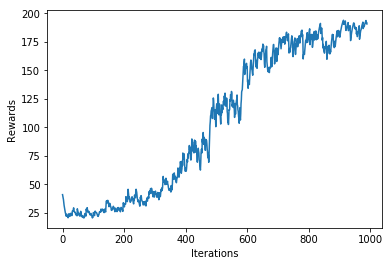

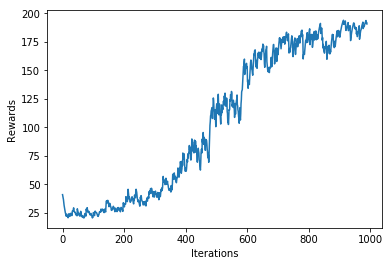

In [0]:
cartpole_model = create_cartpole_model()

smoothed_reward = util.LossHistory(smoothing_factor=0.9)
plotter = util.PeriodicPlotter(sec=5, xlabel='Iterations', ylabel='Rewards')

for i_episode in range(1000):
  
  plotter.plot(smoothed_reward.get())
  
  # Restart the environment
  observation = env.reset()
  
  while True:
    # using our observation, take an action
    action = choose_action(cartpole_model, observation)
    next_observation, reward, done, info = env.step(action)
    # add to memory
    memory.add_to_memory(observation, action, reward)
    
    # is the episode over? did you chrash or do so well that you´re done?
    if done:
      # determine total reward and keep a record of this
      total_reward = sum(memory.rewards)
      smoothed_reward.append( total_reward)
      
      # initiate training - remember we don´t know anything about how the agent is doing until it´s crashed!
      train_step(cartpole_model,
                 optimizer,
                 observations = np.vstack(memory.observations),
                 actions = np.array(memory.actions),
                 discounted_rewards = discount_rewards(memory.rewards)
                 )
      
      memory.clear()
      break
    # update our observations
    observation = next_observation

### 1.6 Save a video of trained model while it is balancing the pole

In [0]:
def save_video_of_model(model, env_name, filename='agent.mp4'):
  import skvideo.io
  from pyvirtualdisplay import Display
  display = Display(visible=0, size=(40,30))
  display.start()
  
  env = gym.make(env_name)
  obs = env.reset()
  shape = env.render(mode='rgb_array').shape[0:2]
  
  out = skvideo.io.FFmpegWriter(filename)
  
  done = False
  while not done:
    frame = env.render(mode='rgb_array')
    out.writeFrame(frame)
    
    action = model(tf.convert_to_tensor(obs.reshape((1,-1)), tf.float32)).numpy().argmax()
    obs, reward, done, nfo = env.step(action)
  out.close()
  print("Successfully saved into {}!".format(filename))
  
save_video_of_model(cartpole_model, "CartPole-v0")

Successfully saved into agent.mp4!


### 1.7 Display the saved video

In [0]:
from IPython.display import HTML
import io, base64
video = io.open('./agent.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data ='''
<video controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
</video>'''.format(encoded.decode('ascii')))

## Part 2: Pong

In Cart Pole, we dealt with an environment that was static--in other words, it didn't change over time. What happens if our environment is dynamic and unpredictable? Well that's exactly the case in Pong, since part of the environment is our opposing player. We don't know how our opponent will act or react to our actions, so the complexity of our problem increases. It also becomes much more interesting, since we can compete to beat our opponent.

### 2.1 Define and inspect the environment

In [3]:
env = gym.make("Pong-v0")
env.seed(1) # reproducible, since RL has high variance

[1L, 289714752L]

Observations:
 
 1. RGB image of shape (210, 160, 3)

We can again confim the size of the observation space by query:

In [5]:
print("Environment has observation space = {}".format(env.env.observation_space))

Environment has observation space = Box(210, 160, 3)


In [6]:
'''At every time step, the agent has six actions to choose from: noop, fire, move right, move left, fire right, and fire left.
Let's confirm the size of the action space by querying the environment:'''
n_actions = env.action_space.n
print("Number of possible actions that the agent can choose from = {}".format(n_actions))

Number of possible actions that the agent can choose from = 6
